# Predict Covid cases by region

In [1]:
import pandas as pd 
import matplotlib.pyplot as mtp
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import requests
import awoc
import math

In [2]:
df = pd.read_csv("covid.csv",parse_dates=['last_updated'])
df.head()

df = df[df['new_infections'] >= 0]
df = df[df['new_deaths'] >=0]
df = df[df['new_recovered'] >=0]
df.head()

,Unnamed: 0,country,country_code,last_updated,new_deaths,new_infections,new_recovered
0,0,Afghanistan,AF,2020-02-25 00:00:00+00:00,0,0,0
1,1,Afghanistan,AF,2020-02-26 00:00:00+00:00,0,0,0
2,2,Afghanistan,AF,2020-02-27 00:00:00+00:00,0,0,0
3,3,Afghanistan,AF,2020-02-28 00:00:00+00:00,0,0,0
4,4,Afghanistan,AF,2020-02-29 00:00:00+00:00,0,0,0


## Bar plot for countries with most cases

### For some reason Namibia country code NA is converted to Nan. Filling it

In [3]:
df['country_code'].fillna("NA",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66005 entries, 0 to 66326
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Unnamed: 0      66005 non-null  int64              
 1   country         66005 non-null  object             
 2   country_code    66005 non-null  object             
 3   last_updated    66005 non-null  datetime64[ns, UTC]
 4   new_deaths      66005 non-null  int64              
 5   new_infections  66005 non-null  int64              
 6   new_recovered   66005 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(2)
memory usage: 4.0+ MB


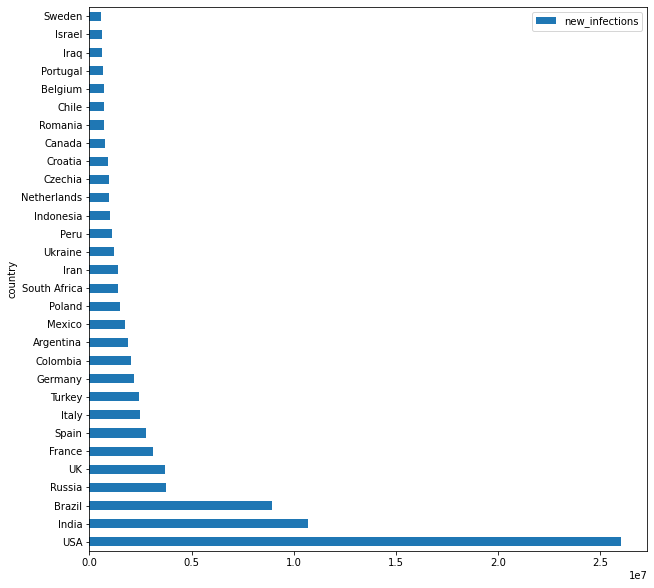

In [4]:
cases_per_country = pd.DataFrame( df.groupby("country")["new_infections"].agg(sum))
cases_sorted_asc = cases_per_country.sort_values("new_infections",ascending=False)[:30]
cases_sorted_asc.plot(kind='barh',figsize=(10,10));


<AxesSubplot:xlabel='last_updated'>

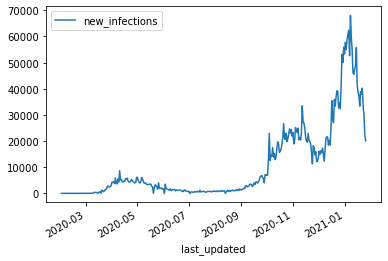

In [5]:
df.sort_values(by='last_updated')
df[df['country_code'] == 'GB'].plot(x="last_updated",y="new_infections")


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
    data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
def normalize_input_dataframe(dataframe):
    df_copy = dataframe.copy()
    df_copy['country_cat'] = df_copy['country_code'].astype('category').cat.codes
    df_copy['timestamp'] = [x.days for x in (df_copy['last_updated'] - df_date_sorted['last_updated'].min())]
    df_copy = df_copy.loc[:,['timestamp','country_cat','country_code']]
    return df_copy




## DecisionTreeRegressor test without any tuning/cross validation
We want to order the dataset by date so to have a ascendent order (chronological). Then we cut 10% from the bottom of the dataset to use as testing data (basically try to estimate the time series)

In [7]:
# sort by date
df_date_sorted = df.sort_values(by=['last_updated'])
df_date_sorted.reset_index(inplace=True,drop=True)
df_date_sorted

,Unnamed: 0,country,country_code,last_updated,new_deaths,new_infections,new_recovered
0,0,Taiwan,TW,2020-01-23 00:00:00+00:00,0,0,0
1,0,Thailand,TH,2020-01-23 00:00:00+00:00,0,1,0
2,0,South Korea,KR,2020-01-23 00:00:00+00:00,0,0,0
3,0,China,CN,2020-01-23 00:00:00+00:00,0,0,0
4,0,Hong Kong,HK,2020-01-23 00:00:00+00:00,0,2,0
...,...,...,...,...,...,...,...
66000,369,China,CN,2021-01-26 00:00:00+00:00,1,82,45
66001,316,Saint Lucia,LC,2021-01-26 00:00:00+00:00,2,35,9
66002,311,Saint Martin,MF,2021-01-26 00:00:00+00:00,0,0,0
66003,270,Comoros,KM,2021-01-26 00:00:00+00:00,1,75,17


In [143]:

#cut X and Ys 
df_date_sorted = df_date_sorted.loc[df_date_sorted['country_code'] == 'GB']
day_diff_df = df_date_sorted[['last_updated','new_infections']]
day_diff_df.reset_index(inplace=True,drop=True)
day_diff_df['last_updated'][0]
day_diff_df['diff_days'] = (day_diff_df['last_updated'] - day_diff_df['last_updated'][0])
day_diff_df['diff_days']= day_diff_df['diff_days'].dt.days
day_diff_df.set_index('last_updated')
X = day_diff_df['diff_days']
Y = df_date_sorted['new_infections']
Y
#X = df_date_sorted.drop(['new_deaths','new_infections','new_recovered'],1)
#Y_Cases = df_date_sorted['new_infections']
#Y_Fatalities = df_date_sorted['new_deaths']

#normalise input data for training
#X_with_countries = normalize_input_dataframe(X)
#X = X_with_countries.drop('country_code',1)
#time_series_df = series_to_supervised(list(Y_Cases),13,1)
#X_time_series = time_series_df.drop('var1(t)',1)
#Y_time_series = time_series_df['var1(t)']

<ipython-input-143-d3e3a4f161b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_diff_df['diff_days'] = (day_diff_df['last_updated'] - day_diff_df['last_updated'][0])
<ipython-input-143-d3e3a4f161b3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_diff_df['diff_days']= day_diff_df['diff_days'].dt.days


151          0
172          0
202          0
220          0
243          0
         ...  
64968    40261
65353    33552
65471    30004
65737    22195
65932    20088
Name: new_infections, Length: 356, dtype: int64

In [9]:
series_to_supervised(list(Y_Cases),3,1,False)

,var1(t-3),var1(t-2),var1(t-1),var1(t)
0,NaN,NaN,NaN,0
1,NaN,NaN,0.0,0
2,NaN,0.0,0.0,0
3,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0
...,...,...,...,...
351,33355.0,38905.0,37892.0,40261
352,38905.0,37892.0,40261.0,33552
353,37892.0,40261.0,33552.0,30004
354,40261.0,33552.0,30004.0,22195


In [144]:
X.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [11]:
Y_time_series

13         0
14         0
15         0
16         0
17         0
       ...  
351    40261
352    33552
353    30004
354    22195
355    20088
Name: var1(t), Length: 343, dtype: int64

In [148]:
#split train and test models for ConfirmedCases
X_cases_train,X_cases_test,Y_cases_train,Y_cases_test = train_test_split(X,Y,test_size=0.2, shuffle=False)
#split train and test models for Fatalities
#X_fat_train,X_fat_test,Y_fat_train,Y_fat_test = train_test_split(X,Y_Fatalities,test_size=0.1,shuffle = True)
#training model and calculating sqrt mean squared log error on test set
model_cases = linear_model.LinearRegression()

#model_fatalities = RandomForestRegressor()
X_cases_train

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
      

In [145]:
X = X.values.reshape(-1,1)

In [146]:
Y = Y.values

In [171]:
Y.shape

(356,)

### Train and test model for Confirmed Cases

In [149]:
model_cases.fit(X,Y)
predictions = model_cases.predict(X_cases_test)
predictions
math.sqrt(mean_squared_log_error(Y_cases_test,predictions))


0.4588440856407016

### Train and test model for Fatalities

In [14]:
#model_fatalities.fit(X_fat_train,Y_fat_train)
#predictions = model_fatalities.predict(X_fat_test)
#math.sqrt(mean_squared_log_error(Y_fat_test,predictions))

## Cross validation of DecisionTreeRegressor

In [15]:
#X_with_countries[X_with_countries['country_code']=='GB']

In [16]:
time_series_df.tail(1)

,var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
355,47525.0,48682.0,55761.0,41342.0,38598.0,37535.0,33355.0,38905.0,37892.0,40261.0,33552.0,30004.0,22195.0,20088


In [17]:
def predict_n_days(history,days):
    history_copy = history.copy()
    results = []
    for i in range(days):
        to_predict = history_copy.tail(1).values
        value = to_predict[0][1::]
        result = model_cases.predict([value])[0]
        results.append(result)
        value = np.append(value,result)
        history_copy = history_copy.append(pd.DataFrame(value.reshape(1,-1), columns=list(history_copy)), ignore_index=True)
        X_time_series = time_series_df.drop('var1(t)',1)
        Y_time_series = time_series_df['var1(t)']
        model_cases.fit(X_time_series,Y_time_series)
    return results

In [18]:

predict_n_days(time_series_df,1000)


[19829.27000998317,
 21869.380012627505,
 21286.86968465426,
 18157.19130207738,
 15232.372631579368,
 10988.923217285013,
 9695.354852712568,
 8842.341934316444,
 9439.492899150515,
 8503.934164258648,
 7388.849333862437,
 5374.85224267332,
 3500.671208126252,
 2249.3656068473365,
 1732.3620686747736,
 1725.9144560723007,
 1277.3388130187227,
 801.0866409161833,
 -239.57675174812198,
 -1102.919507772056,
 -1822.6802364337786,
 -2020.3687300108777,
 -2091.3308749570033,
 -2141.3625605336288,
 -2310.736290065585,
 -2646.9387744800856,
 -2964.6047968406024,
 -3190.705780543861,
 -3167.432965555481,
 -3076.5354539559053,
 -2910.204744742703,
 -2818.7167901654884,
 -2766.260406065853,
 -2739.7681479768153,
 -2643.8628019005096,
 -2455.0657261461065,
 -2203.707677869716,
 -1914.8470055958996,
 -1648.3383550967278,
 -1398.6949541274535,
 -1167.155245876948,
 -901.1240083030839,
 -601.3710854766721,
 -262.12035050981285,
 91.0281437642185,
 440.6478891329431,
 775.8794136758534,
 1102.1234926

In [150]:
test_predictions = model_cases.predict(X.values.reshape(-1,1))
mtp.plot(X,test_predictions)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [172]:
predictions = model_cases.predict([[i] for i in range(1,1000)])
predictions.shape

(999,)

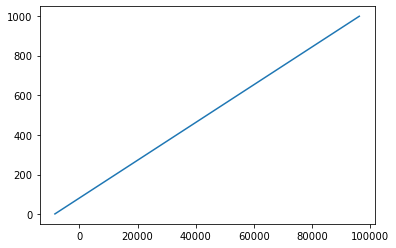

In [173]:
mtp.plot(predictions,np.array([i for i in range(1,1000)]))